In [1]:
# !pip install 'zarr<3'
# !pip install timm


In [2]:
# ALWAYS RUN THIS FIRST!
import os
import sys
from pathlib import Path

NOTEBOOK_DIR = Path("/rsrch9/home/plm/idso_fa1_pathology/codes/yshokrollahi/vitamin-p-latest")
os.chdir(NOTEBOOK_DIR)
sys.path.insert(0, str(NOTEBOOK_DIR))

print(f"✅ Working directory: {os.getcwd()}")

✅ Working directory: /rsrch9/home/plm/idso_fa1_pathology/codes/yshokrollahi/vitamin-p-latest


## Load pannuke

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Dataset paths
pannuke_path = Path("/rsrch9/home/plm/idso_fa1_pathology/TIER1/yasin-vitaminp/public-datasets/PanNuke")
fold2_path = pannuke_path / "Fold 2"

# Load images, types, and masks
images_npy = fold2_path / "images/fold2/images.npy"
types_npy = fold2_path / "images/fold2/types.npy"
masks_npy = fold2_path / "masks/fold2/masks.npy"

print("📥 Loading PanNuke Fold 2 data...")
images = np.load(images_npy, mmap_mode='r')  # Memory-mapped for efficiency
types = np.load(types_npy)
masks = np.load(masks_npy, mmap_mode='r')

print(f"\n✅ Loaded successfully!")
print(f"  Images shape: {images.shape} - dtype: {images.dtype}")
print(f"  Types shape: {types.shape} - dtype: {types.dtype}")
print(f"  Masks shape: {masks.shape} - dtype: {masks.dtype}")

# Check unique tissue types
unique_types = np.unique(types)
print(f"\n🔬 Unique tissue types ({len(unique_types)}):")
for tissue_type in unique_types[:5]:  # First 5
    count = np.sum(types == tissue_type)
    print(f"  - {tissue_type}: {count} images")
print(f"  ... and {len(unique_types) - 5} more")

# Check mask channels (should be 6: 5 cell types + background)
print(f"\n🎭 Mask channels: {masks.shape[-1]}")
print("  Channel mapping:")
print("    0: Neoplastic cells")
print("    1: Inflammatory") 
print("    2: Connective/Soft tissue")
print("    3: Dead cells")
print("    4: Epithelial")
print("    5: Background")

print(f"\n📌 Value ranges:")
print(f"  Images: [{images.min():.3f}, {images.max():.3f}]")
print(f"  Masks: [{masks.min()}, {masks.max()}]")

📥 Loading PanNuke Fold 2 data...

✅ Loaded successfully!
  Images shape: (2523, 256, 256, 3) - dtype: float64
  Types shape: (2523,) - dtype: <U13
  Masks shape: (2523, 256, 256, 6) - dtype: float64

🔬 Unique tissue types (19):
  - Adrenal_gland: 148 images
  - Bile-duct: 103 images
  - Bladder: 61 images
  - Breast: 749 images
  - Cervix: 52 images
  ... and 14 more

🎭 Mask channels: 6
  Channel mapping:
    0: Neoplastic cells
    1: Inflammatory
    2: Connective/Soft tissue
    3: Dead cells
    4: Epithelial
    5: Background

📌 Value ranges:
  Images: [0.000, 255.000]
  Masks: [0.0, 3515.0]


## Run vitaminp Flex

✓ VitaminPFlex initialized with base backbone
  Architecture: Shared Encoder → 4 Separate Decoders
  Embed dim: 768 | Decoder dims: [768, 384, 192, 96]
Selected sample 2321 - Tissue type: Stomach
✓ Padded input from 256x256 to 512x512 (pad: 128px)
🔮 Running inference...
✓ Cropped predictions back to 256x256
✅ Inference complete!
🔧 Post-processing nuclei instances...
🔧 Post-processing cell instances...
✓ Detected 49 nuclei, 41 cells


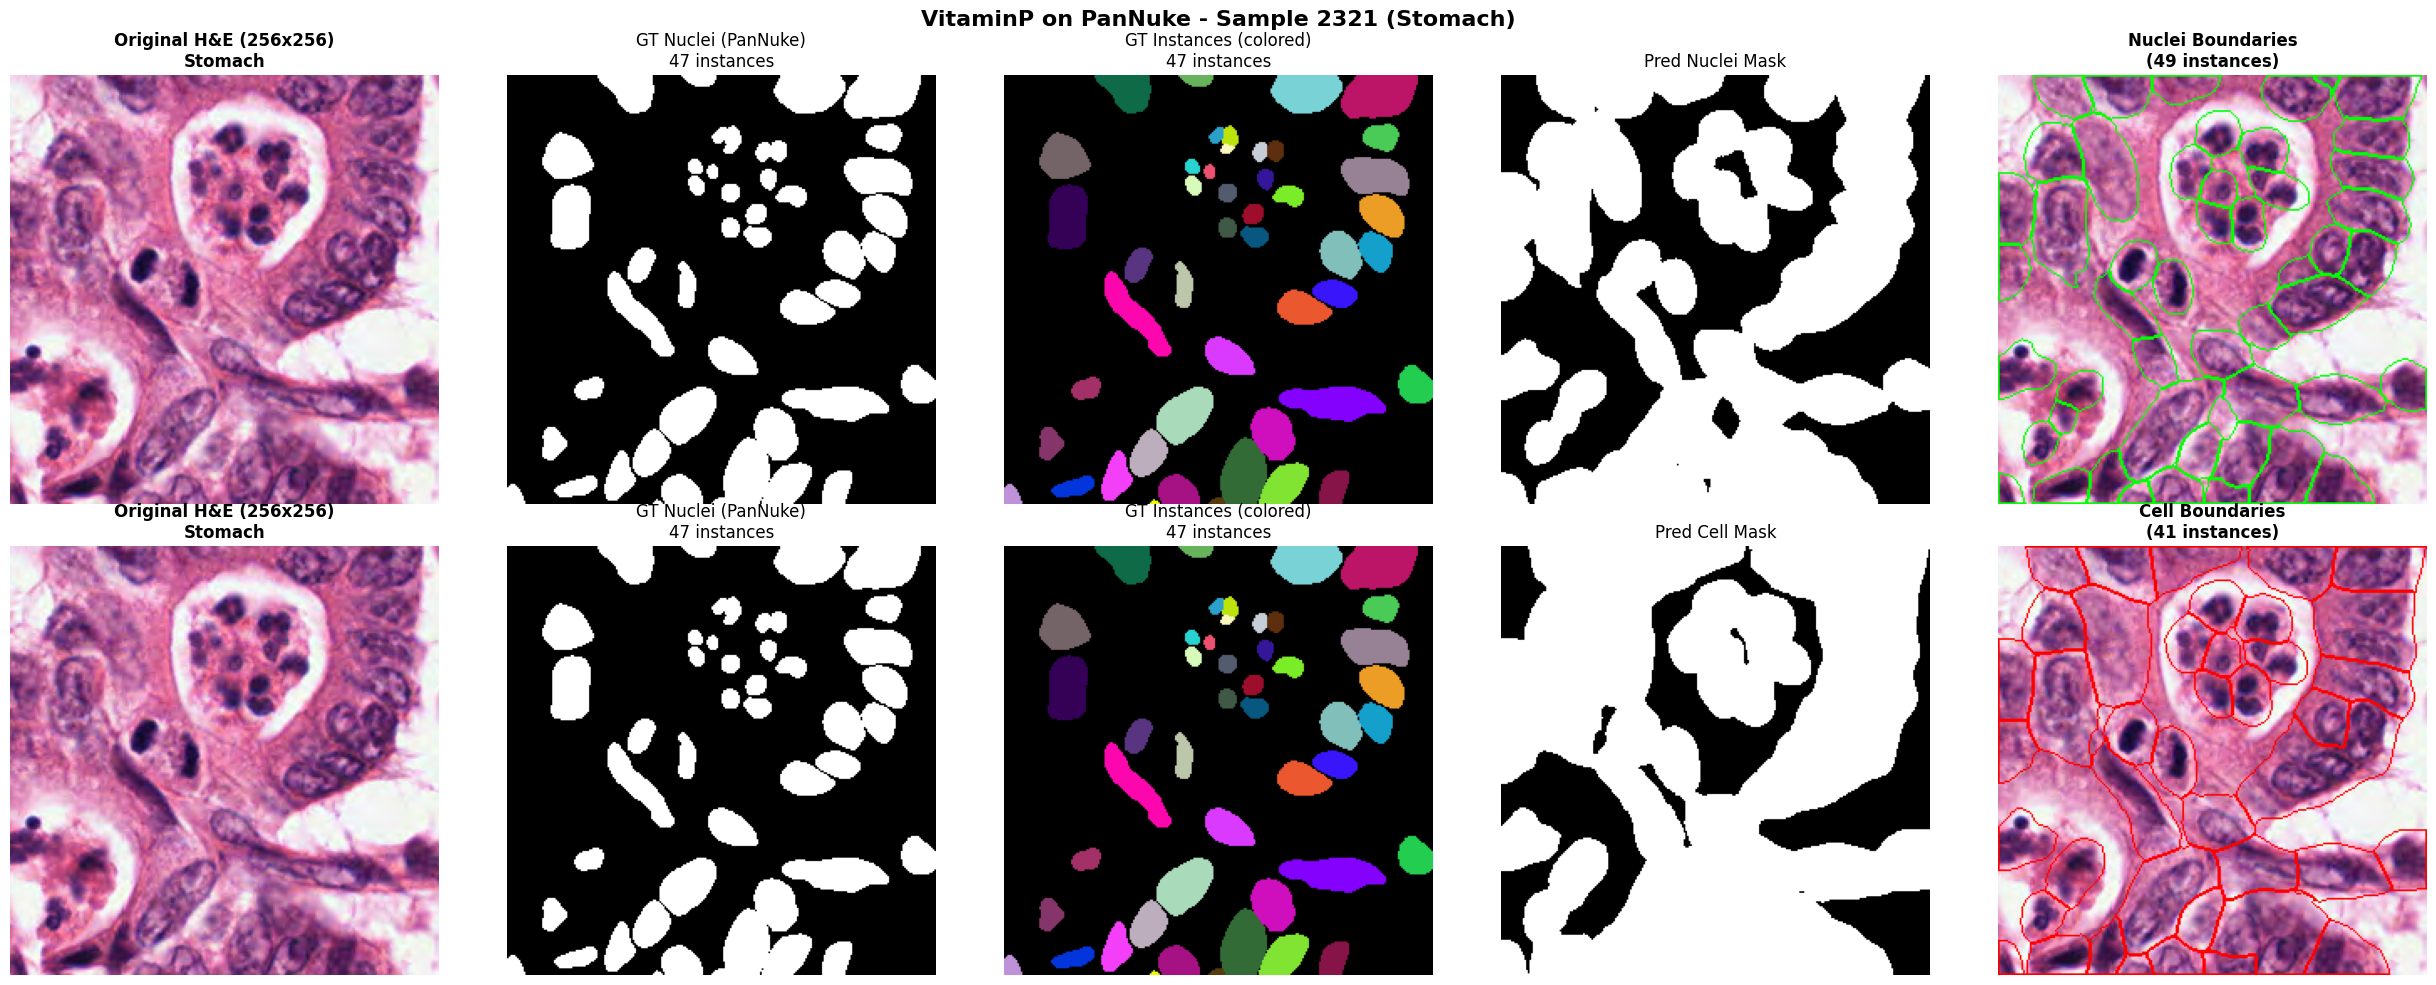

In [26]:
import torch
import torch.nn.functional as F
import cv2
import numpy as np
from vitaminp import VitaminPFlex, SimplePreprocessing, prepare_he_input
from postprocessing import process_model_outputs

# Setup device and model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VitaminPFlex(model_size='base').to(device)
model.load_state_dict(torch.load("checkpoints/vitamin_p_flex_base_fold21_best.pth", map_location=device))
model.eval()

preprocessor = SimplePreprocessing()

# Select a random sample
import random
idx = random.randint(0, len(images) - 1)
print(f"Selected sample {idx} - Tissue type: {types[idx]}")

# Prepare input - PAD from 256x256 to 512x512
he_img = images[idx].copy()  # Shape: (256, 256, 3)

# Convert to tensor
he_img_tensor = torch.from_numpy(he_img).float().permute(2, 0, 1).unsqueeze(0).to(device)  # [1, 3, 256, 256]

# PAD to 512x512 (symmetric padding: 128 pixels on each side)
pad_size = (512 - 256) // 2  # 128
he_img_tensor_padded = F.pad(he_img_tensor, (pad_size, pad_size, pad_size, pad_size), mode='reflect')
print(f"✓ Padded input from 256x256 to {he_img_tensor_padded.shape[2]}x{he_img_tensor_padded.shape[3]} (pad: {pad_size}px)")

# Normalize
he_img_tensor_padded = preprocessor.percentile_normalize(he_img_tensor_padded)

# Get predictions
print("🔮 Running inference...")
with torch.no_grad():
    outputs = model(he_img_tensor_padded)
    
    # Nuclei predictions (512x512) - CROP back to 256x256
    pred_nuclei_mask_full = (outputs['he_nuclei_seg'][0, 0] > 0.5).float().cpu().numpy()
    pred_nuclei_hv_full = outputs['he_nuclei_hv'][0].cpu().numpy()  # [2, 512, 512]
    
    # CROP predictions back to original size (remove padding)
    pred_nuclei_mask = pred_nuclei_mask_full[pad_size:-pad_size, pad_size:-pad_size]
    pred_nuclei_hv = pred_nuclei_hv_full[:, pad_size:-pad_size, pad_size:-pad_size]
    
    # Cell predictions (512x512) - CROP back to 256x256
    pred_cell_mask_full = (outputs['he_cell_seg'][0, 0] > 0.5).float().cpu().numpy()
    pred_cell_hv_full = outputs['he_cell_hv'][0].cpu().numpy()  # [2, 512, 512]
    
    pred_cell_mask = pred_cell_mask_full[pad_size:-pad_size, pad_size:-pad_size]
    pred_cell_hv = pred_cell_hv_full[:, pad_size:-pad_size, pad_size:-pad_size]

print(f"✓ Cropped predictions back to 256x256")

# Get ground truth from PanNuke masks (already 256x256)
gt_masks = masks[idx]  # Shape: (256, 256, 6)
gt_nuclei = (gt_masks[:, :, :5].sum(axis=2) > 0).astype(np.float32)  # (256, 256)

# Create GT instance map from PanNuke masks
gt_inst_map = np.zeros((256, 256), dtype=np.int32)
inst_id = 1
for ch in range(5):  # 5 cell type channels
    channel_mask = gt_masks[:, :, ch]
    unique_instances = np.unique(channel_mask)
    for uid in unique_instances:
        if uid == 0:  # Skip background
            continue
        mask = (channel_mask == uid)
        gt_inst_map[mask] = inst_id
        inst_id += 1
num_gt_nuclei = inst_id - 1

print("✅ Inference complete!")

# Post-process to get instances
print("🔧 Post-processing nuclei instances...")
nuclei_inst, nuclei_info, num_nuclei = process_model_outputs(
    seg_pred=pred_nuclei_mask,
    h_map=pred_nuclei_hv[0],
    v_map=pred_nuclei_hv[1],
    magnification=40
)

print("🔧 Post-processing cell instances...")
cell_inst, cell_info, num_cells = process_model_outputs(
    seg_pred=pred_cell_mask,
    h_map=pred_cell_hv[0],
    v_map=pred_cell_hv[1],
    magnification=40
)

print(f"✓ Detected {num_nuclei} nuclei, {num_cells} cells")

# Function to colorize instance maps
def colorize_instances(inst_map):
    """Assign random colors to each instance"""
    colored = np.zeros((*inst_map.shape, 3), dtype=np.uint8)
    unique_ids = np.unique(inst_map)
    
    np.random.seed(42)  # For consistent colors
    for inst_id in unique_ids:
        if inst_id == 0:  # Skip background
            continue
        mask = inst_map == inst_id
        color = np.random.randint(0, 255, 3)
        colored[mask] = color
    
    return colored

# Draw contours function
def draw_contours_simple(image, inst_info_dict, color=(0, 255, 0), thickness=1):
    if image.max() <= 1.0:
        image = (image * 255).astype(np.uint8)
    else:
        image = image.astype(np.uint8)
    
    if len(image.shape) == 2:
        output = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    elif image.shape[2] == 3:
        output = image.copy()
    
    for inst_id, inst_data in inst_info_dict.items():
        contour = inst_data['contour']
        if contour.shape[0] >= 3:
            cv2.drawContours(output, [contour], -1, color, thickness)
    
    return output

# Prepare visualization (original 256x256)
img_viz = (he_img * 255).astype(np.uint8) if he_img.max() <= 1.0 else he_img.astype(np.uint8)

# Colorize GT and predicted instances
gt_colored = colorize_instances(gt_inst_map)
pred_nuclei_colored = colorize_instances(nuclei_inst)
pred_cell_colored = colorize_instances(cell_inst)

nuclei_contours = draw_contours_simple(img_viz.copy(), nuclei_info, color=(0, 255, 0), thickness=1)
cell_contours = draw_contours_simple(img_viz.copy(), cell_info, color=(255, 0, 0), thickness=1)

# Visualization
fig, axes = plt.subplots(2, 5, figsize=(25, 10))

# Row 1: Nuclei
axes[0, 0].imshow(img_viz)
axes[0, 0].set_title(f'Original H&E (256x256)\n{types[idx]}', fontsize=12, fontweight='bold')
axes[0, 0].axis('off')

axes[0, 1].imshow(gt_nuclei, cmap='gray')
axes[0, 1].set_title(f'GT Nuclei (PanNuke)\n{num_gt_nuclei} instances', fontsize=12)
axes[0, 1].axis('off')

axes[0, 2].imshow(gt_colored)
axes[0, 2].set_title(f'GT Instances (colored)\n{num_gt_nuclei} instances', fontsize=12)
axes[0, 2].axis('off')

axes[0, 3].imshow(pred_nuclei_mask, cmap='gray')
axes[0, 3].set_title('Pred Nuclei Mask', fontsize=12)
axes[0, 3].axis('off')

axes[0, 4].imshow(nuclei_contours)
axes[0, 4].set_title(f'Nuclei Boundaries\n({num_nuclei} instances)', fontsize=12, fontweight='bold')
axes[0, 4].axis('off')

# Row 2: Cells
axes[1, 0].imshow(img_viz)
axes[1, 0].set_title(f'Original H&E (256x256)\n{types[idx]}', fontsize=12, fontweight='bold')
axes[1, 0].axis('off')

axes[1, 1].imshow(gt_nuclei, cmap='gray')
axes[1, 1].set_title(f'GT Nuclei (PanNuke)\n{num_gt_nuclei} instances', fontsize=12)
axes[1, 1].axis('off')

axes[1, 2].imshow(gt_colored)
axes[1, 2].set_title(f'GT Instances (colored)\n{num_gt_nuclei} instances', fontsize=12)
axes[1, 2].axis('off')

axes[1, 3].imshow(pred_cell_mask, cmap='gray')
axes[1, 3].set_title('Pred Cell Mask', fontsize=12)
axes[1, 3].axis('off')

axes[1, 4].imshow(cell_contours)
axes[1, 4].set_title(f'Cell Boundaries\n({num_cells} instances)', fontsize=12, fontweight='bold')
axes[1, 4].axis('off')

plt.suptitle(f'VitaminP on PanNuke - Sample {idx} ({types[idx]})', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

## Pannuke instance metrics with Flex

In [19]:
import torch
import torch.nn.functional as F
import numpy as np
from collections import defaultdict
from metrics import (
    get_fast_pq,
    aggregated_jaccard_index
)
from vitaminp import VitaminPFlex, SimplePreprocessing
from postprocessing import process_model_outputs
from tqdm import tqdm

# Setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load model
print("\n📦 Loading model...")
model = VitaminPFlex(model_size='large').to(device)
checkpoint_path = "checkpoints/vitamin_p_flex_large_fold2_best.pth"
model.load_state_dict(torch.load(checkpoint_path, map_location=device))
model.eval()
print(f"✅ Model loaded")

# Preprocessor
preprocessor = SimplePreprocessing()

# PanNuke specific settings
pad_size = (512 - 256) // 2  # 128 pixels padding

# Initialize metric storage
pannuke_metrics = {
    'nuclei_pq': [], 'nuclei_dq': [], 'nuclei_sq': [], 'nuclei_aji': [],
}

tissue_type_metrics = defaultdict(lambda: {
    'nuclei_pq': [], 'nuclei_dq': [], 'nuclei_sq': [], 'nuclei_aji': [], 'count': 0
})

print(f"\n🔄 Evaluating on PanNuke Fold 2 ({len(images)} samples)...")
print(f"Using padding: {pad_size}px on each side (256→512)")

skipped_samples = 0

with torch.no_grad():
    for idx in tqdm(range(len(images)), desc="Processing samples"):
        try:
            # Load image and mask
            he_img = images[idx].copy()  # (256, 256, 3)
            gt_masks = masks[idx]  # (256, 256, 6)
            tissue_type = types[idx]
            
            # Create GT instance map from PanNuke masks
            gt_inst_map = np.zeros((256, 256), dtype=np.int32)
            inst_id = 1
            for ch in range(5):  # 5 cell type channels
                channel_mask = gt_masks[:, :, ch]
                unique_instances = np.unique(channel_mask)
                for uid in unique_instances:
                    if uid == 0:  # Skip background
                        continue
                    mask = (channel_mask == uid)
                    gt_inst_map[mask] = inst_id
                    inst_id += 1
            
            # Convert to tensor and PAD to 512x512
            he_img_tensor = torch.from_numpy(he_img).float().permute(2, 0, 1).unsqueeze(0).to(device)  # [1, 3, 256, 256]
            he_img_tensor_padded = F.pad(he_img_tensor, (pad_size, pad_size, pad_size, pad_size), mode='reflect')
            
            # Normalize
            he_img_tensor_padded = preprocessor.percentile_normalize(he_img_tensor_padded)
            
            # ========== INFERENCE ==========
            outputs = model(he_img_tensor_padded)
            
            # Get nuclei predictions (512x512) and CROP back to 256x256
            pred_nuclei_mask_full = (outputs['he_nuclei_seg'][0, 0] > 0.5).float().cpu().numpy()
            pred_nuclei_hv_full = outputs['he_nuclei_hv'][0].cpu().numpy()  # [2, 512, 512]
            
            # CROP predictions back to original size (remove padding)
            pred_nuclei_mask = pred_nuclei_mask_full[pad_size:-pad_size, pad_size:-pad_size]
            pred_nuclei_hv = pred_nuclei_hv_full[:, pad_size:-pad_size, pad_size:-pad_size]
            
            # Post-process to get instance map
            nuclei_inst_pred, _, _ = process_model_outputs(
                pred_nuclei_mask,
                pred_nuclei_hv[0],  # h_map
                pred_nuclei_hv[1],  # v_map
                magnification=40
            )
            
            # Compute instance metrics
            nuclei_pq, nuclei_dq, nuclei_sq = get_fast_pq(gt_inst_map, nuclei_inst_pred)
            nuclei_aji = aggregated_jaccard_index(gt_inst_map, nuclei_inst_pred)
            
            # Store overall metrics
            pannuke_metrics['nuclei_pq'].append(nuclei_pq)
            pannuke_metrics['nuclei_dq'].append(nuclei_dq)
            pannuke_metrics['nuclei_sq'].append(nuclei_sq)
            pannuke_metrics['nuclei_aji'].append(nuclei_aji)
            
            # Store per-tissue-type metrics
            tissue_type_metrics[tissue_type]['nuclei_pq'].append(nuclei_pq)
            tissue_type_metrics[tissue_type]['nuclei_dq'].append(nuclei_dq)
            tissue_type_metrics[tissue_type]['nuclei_sq'].append(nuclei_sq)
            tissue_type_metrics[tissue_type]['nuclei_aji'].append(nuclei_aji)
            tissue_type_metrics[tissue_type]['count'] += 1
            
        except Exception as e:
            print(f"\n⚠️ Skipping sample {idx} due to error: {str(e)[:100]}")
            skipped_samples += 1
            continue

# ========== OVERALL RESULTS ==========
print("\n" + "="*100)
print("📊 OVERALL PANNUKE FOLD 2 RESULTS - NUCLEI INSTANCE METRICS")
print("="*100)

print(f"\nTotal samples processed: {len(pannuke_metrics['nuclei_pq'])}")
if skipped_samples > 0:
    print(f"⚠️ Skipped samples: {skipped_samples}")

print("\n🔬 NUCLEI INSTANCE METRICS (all samples):")
print(f"  PQ (Panoptic Quality):     {np.mean(pannuke_metrics['nuclei_pq']):.4f} ± {np.std(pannuke_metrics['nuclei_pq']):.4f}")
print(f"  DQ (Detection Quality):    {np.mean(pannuke_metrics['nuclei_dq']):.4f} ± {np.std(pannuke_metrics['nuclei_dq']):.4f}")
print(f"  SQ (Segmentation Quality): {np.mean(pannuke_metrics['nuclei_sq']):.4f} ± {np.std(pannuke_metrics['nuclei_sq']):.4f}")
print(f"  AJI (Agg. Jaccard):        {np.mean(pannuke_metrics['nuclei_aji']):.4f} ± {np.std(pannuke_metrics['nuclei_aji']):.4f}")

# ========== PER-TISSUE-TYPE RESULTS ==========
print("\n" + "="*100)
print("📊 PER-TISSUE-TYPE RESULTS")
print("="*100)
print(f"{'Tissue Type':<20} {'Count':>8} {'PQ':>10} {'DQ':>10} {'SQ':>10} {'AJI':>10}")
print("-" * 100)

for tissue_type in sorted(tissue_type_metrics.keys()):
    metrics = tissue_type_metrics[tissue_type]
    print(f"{tissue_type:<20} {metrics['count']:>8} "
          f"{np.mean(metrics['nuclei_pq']):>10.4f} "
          f"{np.mean(metrics['nuclei_dq']):>10.4f} "
          f"{np.mean(metrics['nuclei_sq']):>10.4f} "
          f"{np.mean(metrics['nuclei_aji']):>10.4f}")

# ========== TOP/BOTTOM PERFORMERS ==========
print("\n" + "="*100)
print("🏆 TOP 5 TISSUE TYPES (by PQ)")
print("="*100)

tissue_pq_sorted = sorted(tissue_type_metrics.items(), 
                          key=lambda x: np.mean(x[1]['nuclei_pq']), 
                          reverse=True)

for i, (tissue_type, metrics) in enumerate(tissue_pq_sorted[:5], 1):
    print(f"{i}. {tissue_type:<20} PQ: {np.mean(metrics['nuclei_pq']):.4f} "
          f"(n={metrics['count']})")

print("\n" + "="*100)
print("⚠️  BOTTOM 5 TISSUE TYPES (by PQ)")
print("="*100)

for i, (tissue_type, metrics) in enumerate(tissue_pq_sorted[-5:], 1):
    print(f"{i}. {tissue_type:<20} PQ: {np.mean(metrics['nuclei_pq']):.4f} "
          f"(n={metrics['count']})")

print("\n" + "="*100)
print("✅ PanNuke evaluation complete!")
print("="*100)

Using device: cuda

📦 Loading model...
✓ VitaminPFlex initialized with large backbone
  Architecture: Shared Encoder → 4 Separate Decoders
  Embed dim: 1024 | Decoder dims: [1024, 512, 256, 128]
✅ Model loaded

🔄 Evaluating on PanNuke Fold 2 (2523 samples)...
Using padding: 128px on each side (256→512)


Processing samples: 100%|██████████| 2523/2523 [02:46<00:00, 15.20it/s]


📊 OVERALL PANNUKE FOLD 2 RESULTS - NUCLEI INSTANCE METRICS

Total samples processed: 2523

🔬 NUCLEI INSTANCE METRICS (all samples):
  PQ (Panoptic Quality):     0.5299 ± 0.2159
  DQ (Detection Quality):    0.6640 ± 0.2529
  SQ (Segmentation Quality): 0.7358 ± 0.2102
  AJI (Agg. Jaccard):        0.5559 ± 0.2249

📊 PER-TISSUE-TYPE RESULTS
Tissue Type             Count         PQ         DQ         SQ        AJI
----------------------------------------------------------------------------------------------------
Adrenal_gland             148     0.5567     0.6773     0.7764     0.5750
Bile-duct                 103     0.5358     0.6556     0.7169     0.5666
Bladder                    61     0.5505     0.6612     0.7124     0.5648
Breast                    749     0.5711     0.7288     0.7623     0.6042
Cervix                     52     0.5020     0.6150     0.7380     0.5235
Colon                     468     0.4262     0.5450     0.6623     0.4543
Esophagus                 128     0.5477 

## HE Baseline

In [21]:
import torch
import torch.nn.functional as F
import numpy as np
from collections import defaultdict
from metrics import (
    get_fast_pq,
    aggregated_jaccard_index
)
from vitaminp import VitaminPBaselineHE, SimplePreprocessing, prepare_he_input
from postprocessing import process_model_outputs
from tqdm import tqdm

# Setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load H&E BASELINE model
print("\n📦 Loading VitaminPBaselineHE model...")
model = VitaminPBaselineHE(model_size='large', dropout_rate=0.3, freeze_backbone=False)
checkpoint_path = "checkpoints/vitamin_p_baselinehe_large_fold3_best.pth"
model.load_state_dict(torch.load(checkpoint_path, map_location=device))
model.eval()
model = model.to(device)
print(f"✅ VitaminPBaselineHE model loaded")

# Preprocessor
preprocessor = SimplePreprocessing()

# PanNuke specific settings
pad_size = (512 - 256) // 2  # 128 pixels padding

# Initialize metric storage
pannuke_metrics = {
    'nuclei_pq': [], 'nuclei_dq': [], 'nuclei_sq': [], 'nuclei_aji': [],
}

tissue_type_metrics = defaultdict(lambda: {
    'nuclei_pq': [], 'nuclei_dq': [], 'nuclei_sq': [], 'nuclei_aji': [], 'count': 0
})

print(f"\n🔄 Evaluating VitaminPBaselineHE on PanNuke Fold 2 ({len(images)} samples)...")
print(f"Using padding: {pad_size}px on each side (256→512)")

skipped_samples = 0

with torch.no_grad():
    for idx in tqdm(range(len(images)), desc="Processing samples"):
        try:
            # Load image and mask
            he_img = images[idx].copy()  # (256, 256, 3)
            gt_masks = masks[idx]  # (256, 256, 6)
            tissue_type = types[idx]
            
            # Create GT instance map from PanNuke masks
            gt_inst_map = np.zeros((256, 256), dtype=np.int32)
            inst_id = 1
            for ch in range(5):  # 5 cell type channels
                channel_mask = gt_masks[:, :, ch]
                unique_instances = np.unique(channel_mask)
                for uid in unique_instances:
                    if uid == 0:  # Skip background
                        continue
                    mask = (channel_mask == uid)
                    gt_inst_map[mask] = inst_id
                    inst_id += 1
            
            # Convert to tensor and PAD to 512x512
            he_img_tensor = torch.from_numpy(he_img).float().permute(2, 0, 1).unsqueeze(0).to(device)  # [1, 3, 256, 256]
            he_img_tensor_padded = F.pad(he_img_tensor, (pad_size, pad_size, pad_size, pad_size), mode='reflect')
            
            # Normalize
            he_img_tensor_padded = preprocessor.percentile_normalize(he_img_tensor_padded)
            
            # ========== INFERENCE WITH H&E BASELINE MODEL ==========
            outputs = model(he_img_tensor_padded)
            
            # Get H&E nuclei predictions (512x512) and CROP back to 256x256
            pred_nuclei_mask_full = (outputs['he_nuclei_seg'][0, 0] > 0.5).float().cpu().numpy()
            pred_nuclei_hv_full = outputs['he_nuclei_hv'][0].cpu().numpy()  # [2, 512, 512]
            
            # CROP predictions back to original size (remove padding)
            pred_nuclei_mask = pred_nuclei_mask_full[pad_size:-pad_size, pad_size:-pad_size]
            pred_nuclei_hv = pred_nuclei_hv_full[:, pad_size:-pad_size, pad_size:-pad_size]
            
            # Post-process to get instance map
            nuclei_inst_pred, _, _ = process_model_outputs(
                pred_nuclei_mask,
                pred_nuclei_hv[0],  # h_map
                pred_nuclei_hv[1],  # v_map
                magnification=40
            )
            
            # Compute instance metrics
            nuclei_pq, nuclei_dq, nuclei_sq = get_fast_pq(gt_inst_map, nuclei_inst_pred)
            nuclei_aji = aggregated_jaccard_index(gt_inst_map, nuclei_inst_pred)
            
            # Store overall metrics
            pannuke_metrics['nuclei_pq'].append(nuclei_pq)
            pannuke_metrics['nuclei_dq'].append(nuclei_dq)
            pannuke_metrics['nuclei_sq'].append(nuclei_sq)
            pannuke_metrics['nuclei_aji'].append(nuclei_aji)
            
            # Store per-tissue-type metrics
            tissue_type_metrics[tissue_type]['nuclei_pq'].append(nuclei_pq)
            tissue_type_metrics[tissue_type]['nuclei_dq'].append(nuclei_dq)
            tissue_type_metrics[tissue_type]['nuclei_sq'].append(nuclei_sq)
            tissue_type_metrics[tissue_type]['nuclei_aji'].append(nuclei_aji)
            tissue_type_metrics[tissue_type]['count'] += 1
            
        except Exception as e:
            print(f"\n⚠️ Skipping sample {idx} due to error: {str(e)[:100]}")
            skipped_samples += 1
            continue

# ========== OVERALL RESULTS ==========
print("\n" + "="*100)
print("📊 OVERALL PANNUKE FOLD 2 RESULTS - NUCLEI INSTANCE METRICS (VitaminPBaselineHE)")
print("="*100)

print(f"\nTotal samples processed: {len(pannuke_metrics['nuclei_pq'])}")
if skipped_samples > 0:
    print(f"⚠️ Skipped samples: {skipped_samples}")

print("\n🔬 NUCLEI INSTANCE METRICS (all samples):")
print(f"  PQ (Panoptic Quality):     {np.mean(pannuke_metrics['nuclei_pq']):.4f} ± {np.std(pannuke_metrics['nuclei_pq']):.4f}")
print(f"  DQ (Detection Quality):    {np.mean(pannuke_metrics['nuclei_dq']):.4f} ± {np.std(pannuke_metrics['nuclei_dq']):.4f}")
print(f"  SQ (Segmentation Quality): {np.mean(pannuke_metrics['nuclei_sq']):.4f} ± {np.std(pannuke_metrics['nuclei_sq']):.4f}")
print(f"  AJI (Agg. Jaccard):        {np.mean(pannuke_metrics['nuclei_aji']):.4f} ± {np.std(pannuke_metrics['nuclei_aji']):.4f}")

# ========== PER-TISSUE-TYPE RESULTS ==========
print("\n" + "="*100)
print("📊 PER-TISSUE-TYPE RESULTS (VitaminPBaselineHE)")
print("="*100)
print(f"{'Tissue Type':<20} {'Count':>8} {'PQ':>10} {'DQ':>10} {'SQ':>10} {'AJI':>10}")
print("-" * 100)

for tissue_type in sorted(tissue_type_metrics.keys()):
    metrics = tissue_type_metrics[tissue_type]
    print(f"{tissue_type:<20} {metrics['count']:>8} "
          f"{np.mean(metrics['nuclei_pq']):>10.4f} "
          f"{np.mean(metrics['nuclei_dq']):>10.4f} "
          f"{np.mean(metrics['nuclei_sq']):>10.4f} "
          f"{np.mean(metrics['nuclei_aji']):>10.4f}")

# ========== TOP/BOTTOM PERFORMERS ==========
print("\n" + "="*100)
print("🏆 TOP 5 TISSUE TYPES (by PQ)")
print("="*100)

tissue_pq_sorted = sorted(tissue_type_metrics.items(), 
                          key=lambda x: np.mean(x[1]['nuclei_pq']), 
                          reverse=True)

for i, (tissue_type, metrics) in enumerate(tissue_pq_sorted[:5], 1):
    print(f"{i}. {tissue_type:<20} PQ: {np.mean(metrics['nuclei_pq']):.4f} "
          f"(n={metrics['count']})")

print("\n" + "="*100)
print("⚠️  BOTTOM 5 TISSUE TYPES (by PQ)")
print("="*100)

for i, (tissue_type, metrics) in enumerate(tissue_pq_sorted[-5:], 1):
    print(f"{i}. {tissue_type:<20} PQ: {np.mean(metrics['nuclei_pq']):.4f} "
          f"(n={metrics['count']})")

print("\n" + "="*100)
print("✅ PanNuke evaluation complete with VitaminPBaselineHE!")
print("="*100)

Using device: cuda

📦 Loading VitaminPBaselineHE model...
Building H&E Baseline encoder with DINOv2-large
✓ VitaminPBaselineHE initialized with large backbone
  Embed dim: 1024 | Decoder dims: [1024, 512, 256, 128]
✅ VitaminPBaselineHE model loaded

🔄 Evaluating VitaminPBaselineHE on PanNuke Fold 2 (2523 samples)...
Using padding: 128px on each side (256→512)


Processing samples: 100%|██████████| 2523/2523 [02:38<00:00, 15.97it/s]


📊 OVERALL PANNUKE FOLD 2 RESULTS - NUCLEI INSTANCE METRICS (VitaminPBaselineHE)

Total samples processed: 2523

🔬 NUCLEI INSTANCE METRICS (all samples):
  PQ (Panoptic Quality):     0.5108 ± 0.2289
  DQ (Detection Quality):    0.6406 ± 0.2715
  SQ (Segmentation Quality): 0.7182 ± 0.2346
  AJI (Agg. Jaccard):        0.5308 ± 0.2408

📊 PER-TISSUE-TYPE RESULTS (VitaminPBaselineHE)
Tissue Type             Count         PQ         DQ         SQ        AJI
----------------------------------------------------------------------------------------------------
Adrenal_gland             148     0.5214     0.6366     0.7378     0.5340
Bile-duct                 103     0.5286     0.6580     0.7057     0.5533
Bladder                    61     0.5190     0.6325     0.6786     0.5346
Breast                    749     0.5651     0.7210     0.7529     0.5893
Cervix                     52     0.4954     0.6054     0.6980     0.5156
Colon                     468     0.3835     0.4874     0.6209     0.4036